## Sentiment Analysis

dataset link: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis?resource=download

(also in this folder)

In [36]:
# imports 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import string
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sayyedjilani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## EDA

In [5]:
# view dataset and labels
movies_df = pd.read_csv('movie.csv')
movies_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
# view distribution of labels
movies_df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [7]:
# view example text
movies_df['text'][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

The text iteslf needs to be processed, which includes removing stop words and break each word down to its indivdual stem

In [19]:
# split dataset 
X = movies_df.drop('label', axis=1).values
y = movies_df['label'].values

# split the data into training and temporary set (80% training + 20% temp set)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# split the temp set into testing and validation sets (80% training, 10% validation and 10% test set of the original dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [44]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

print('split sizes\n')
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)
print('y_test: ', y_test.shape)

split sizes

X_train:  (32000,)
X_val:  (4000,)
X_test:  (4000,)
y_train:  (32000,)
y_val:  (4000,)
y_test:  (4000,)


Do positive film reviews tend to have greater length, or is it the other way around? We can utilze histograms to see the distibution of review length by sentiment.

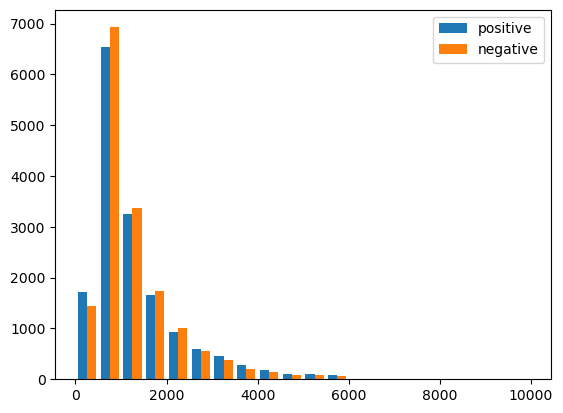

Longest positive review: 13704
Longest negative review: 8969

Longest positive review: 1325.876277669781
Longest negative review: 1285.3457920637886


In [82]:
# a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if y_train[i]]

# a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not y_train[i]]


plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 10000), label=['positive', 'negative'])

plt.legend()
plt.show()

# check the longest reviews
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))
# check avg review length
print('\nLongest positive review:', np.mean(text_lengths_pos))
print('Longest negative review:', np.mean(text_lengths_neg))

On avergae the lengths of the reviews are quite similar. Similarly, the distribution of word lengths is also quite similar across the two classes, and the very large lengths can be considered to be outliers. Given the similar distributions, applying a word count limit as part of our processing may not be neccessary. 

In [39]:
def process_text(text):
    '''
    Input:
        text: a string containing a film review
    Output:
        clean_text: a list of words containing the processed text
    '''

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # tokenize text by only using concurrent letters
    words = re.findall(r'[a-z]+', text.lower())

    clean_text = []
    for word in words:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            clean_text.append(stem_word)

    return clean_text

In [43]:
print('The following is an example text:')
print(X_train[0])
print('\nThefollowing is an example of processed text:')
print(process_text(X_train[0]))

The following is an example text:
I watched it last night and again this morning - that's how much I liked it. There is something about this movie... When the movie was almost over, I was about to cry. I would strongly recommend "Latter Days" to my friends - it's definitely worth seeing! I agree with those who say that some parts of the movie do not look very realistic. For example, both main characters are totally cute and in perfect physical shape (although, round is also a type of shape:) ). I rarely meet people like this as singles and I have never met any in couples. Other parts of the movie, including all those "coincidences", do not look very realistic as well. BUT, after all it is A MOVIE, not a life story.

Thefollowing is an example of processed text:
['watch', 'last', 'night', 'morn', 'much', 'like', 'someth', 'movi', 'movi', 'almost', 'cri', 'would', 'strongli', 'recommend', 'latter', 'day', 'friend', 'definit', 'worth', 'see', 'agre', 'say', 'part', 'movi', 'look', 'realis

In [83]:
# with extremely large datasets (GB to TB), the counts should not be stored in a dictionary. Splitting the data and utilzing the MapReduce paradigm
# over various nodes may become necessary 

def count_text(mapper, X, y):
    '''
    Input:
        mapper: dcitionary used to store tuples of word and sentiment counts
        X: an array of texts
        y: an array of corresponding sentiment of each text 
    Output:
        result: a dictionary mapping each pair to its frequency { (word, sentiment) : count }
    '''
    
    for y, text in zip(y, X):
        for word in process_text(text):

            # word, sentiment tuple as kay
            key = (word, y)
            
            # if the key exists in the dictionary, increment the count
            if mapper.get(key,0) != 0:
                mapper[key] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                mapper[key] = 1

    return mapper

In [84]:
# testing functionality of count_text
count_text({}, X_train[0:3], y_train[0:3])

{('watch', 1): 1,
 ('last', 1): 1,
 ('night', 1): 1,
 ('morn', 1): 1,
 ('much', 1): 1,
 ('like', 1): 3,
 ('someth', 1): 4,
 ('movi', 1): 5,
 ('almost', 1): 1,
 ('cri', 1): 1,
 ('would', 1): 1,
 ('strongli', 1): 1,
 ('recommend', 1): 1,
 ('latter', 1): 1,
 ('day', 1): 1,
 ('friend', 1): 1,
 ('definit', 1): 1,
 ('worth', 1): 1,
 ('see', 1): 1,
 ('agre', 1): 1,
 ('say', 1): 2,
 ('part', 1): 2,
 ('look', 1): 2,
 ('realist', 1): 2,
 ('exampl', 1): 1,
 ('main', 1): 1,
 ('charact', 1): 2,
 ('total', 1): 1,
 ('cute', 1): 1,
 ('perfect', 1): 1,
 ('physic', 1): 1,
 ('shape', 1): 2,
 ('although', 1): 2,
 ('round', 1): 1,
 ('also', 1): 1,
 ('type', 1): 1,
 ('rare', 1): 1,
 ('meet', 1): 1,
 ('peopl', 1): 1,
 ('singl', 1): 1,
 ('never', 1): 1,
 ('met', 1): 1,
 ('coupl', 1): 1,
 ('includ', 1): 1,
 ('coincid', 1): 1,
 ('well', 1): 1,
 ('life', 1): 1,
 ('stori', 1): 2,
 ('western', 1): 2,
 ('one', 1): 2,
 ('favourit', 1): 1,
 ('john', 1): 2,
 ('ford', 1): 3,
 ('lack', 1): 1,
 ('certain', 1): 1,
 ('film

In [85]:
# store training frequencies 
train_freq = count_text({}, X_train, y_train)

## Models

#### Logistic Regression